# Loan Status - The Best Classifier
This dataset is about past loans. The Loan_train.csv data set includes details of 346 customers whose 
loan are already paid off or defaulted.
After data wrangling, use the training set to build an accurate model to predict the loan status of new clients. Then use the test set to report the accuracy of the models and point the best one. Use multiple algorithms to compare.

Training Dataset: https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

Test Dataset (evaluate only): https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

- User Jaccard, F1 and Logloss to evaluate

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss 
%matplotlib inline

In [2]:
df = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv')
print(df.shape)
df.head()

(346, 10)


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [3]:
df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

In [4]:
# 'due_date' , 'effective_date'  to time object
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [5]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

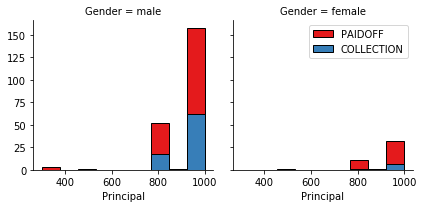

In [6]:
# Plotting loan amount ('Principal') x Loan_Status(paidoff/collection) by gender

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)

#plot data on the grid using FacetGrid.map() method, histogram.
g.map(plt.hist, 'Principal', bins=bins, ec="k") 

g.axes[-1].legend()
plt.show()

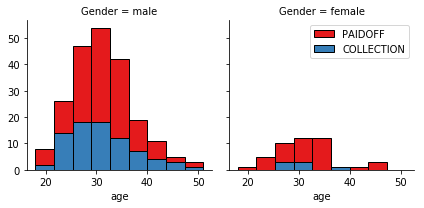

In [7]:
# Plotting age x Loan_Status(paidoff/collection) by gender

bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

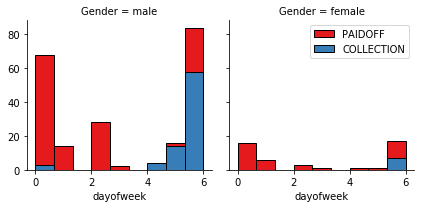

In [8]:
# Day of the week with more loans. Mon-Sun 0-6
df['dayofweek'] = df['effective_date'].dt.dayofweek

#Plotting day of week, gender and loan status
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


### People who get the loan at the end of the week (Fri-Sun) dont pay it off 

In [9]:
# Isolating Fri-Sun loans
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


In [10]:
# Checking loans by gender - normalized
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

### 86% Female pay x 73% male pay

In [11]:
# Converting 0-1
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [12]:
# Loan status x education, normalized
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

In [13]:
# Features
Feature = df[['Principal','terms','age','Gender','weekend']]

# One-hot encoding 'education' to features
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)

df['education'].value_counts(dropna=False)

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

In [14]:
# Only 2 samples Master or Above - drop
Feature.drop(['Master or Above'], axis = 1,inplace=True) 
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [15]:
# Features and target
X = Feature
y = df['loan_status'].values

In [16]:
# Normalize features
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [17]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# Modeling

### KNN

[0.640625   0.59322034 0.69230769 0.63934426 0.734375   0.68253968
 0.765625   0.72580645 0.73846154 0.62295082 0.68181818 0.6984127 ]

max acc[Jaccard]:  0.765625 for K= 7


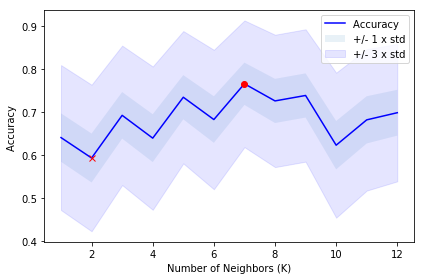

In [18]:
# Finding best K, for K_start = 13
Ks = 13
mean_acc = np.zeros((Ks-1)) #inicializando lista
std_acc = np.zeros((Ks-1))

for k in range(1,Ks):
    
    #Training  
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    
    #Test and Evaluation
    knn_pred = neigh.predict(X_test)
    mean_acc[k-1] = jaccard_score(y_test, knn_pred, pos_label='PAIDOFF')

    
    std_acc[k-1]=np.std(knn_pred==y_test)/np.sqrt(knn_pred.shape[0])

print(mean_acc)# retorna o accuracy usando os dados de TESTE, para k = 1~12
print("\nmax acc[Jaccard]: ", mean_acc.max(), "for K=",mean_acc.argmax()+1)

plt.plot(range(1,Ks),mean_acc,'b')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10) # área +/- 1*std
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="blue") # área +/- 3*std
plt.legend(('Accuracy ', '+/- 1 x std','+/- 3 x std'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')

n_max = mean_acc.argmax()
plt.plot(range(1,Ks)[n_max],mean_acc[n_max],'o',color = 'r') # Max acc
n_min = mean_acc.argmin()
plt.plot(range(1,Ks)[n_min],mean_acc[n_min],'x', color='r') # Min acc
plt.tight_layout()
plt.show()

In [19]:
# Model with best K
best_k = 7
knn_model = KNeighborsClassifier(n_neighbors = best_k).fit(X_train,y_train)

### Decision Tree

Text(0,0.5,'model_score')

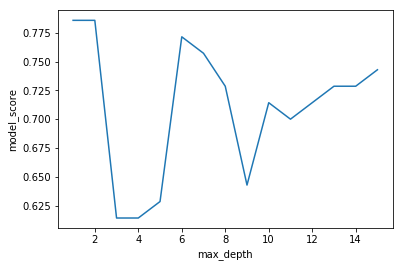

In [20]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 16))# List to store the average RMSE for each value of max_depth:
accuracy = []

for depth in max_depth_range:
    
    clf = DecisionTreeClassifier(max_depth = depth, random_state = 0)
    clf.fit(X_train, y_train)    
    score = clf.score(X_test, y_test)
    accuracy.append(score)
    
plt.plot(max_depth_range, accuracy)
plt.xlabel('max_depth')
plt.ylabel('model_score')

In [21]:
# testing for entropy, best max_depth = 2
tree_model1 = DecisionTreeClassifier(criterion='entropy', max_depth=2)
tree_model1.fit(X_train, y_train)

tree_pred = tree_model1.predict(X_test)

tree_acc =  jaccard_score(y_test, tree_pred, pos_label='PAIDOFF')
print("DecisionTrees's Accuracy[Jaccard] with Entropy: ", tree_acc)

DecisionTrees's Accuracy[Jaccard] with Entropy:  0.7857142857142857


In [22]:
# testing for gini, best max_depth = 2
tree_model1 = DecisionTreeClassifier(criterion='gini', max_depth=2)
tree_model1.fit(X_train, y_train)

tree_pred = tree_model1.predict(X_test)

tree_acc =  jaccard_score(y_test, tree_pred, pos_label='PAIDOFF')
print("DecisionTrees's Accuracy[Jaccard] with Entropy: ", tree_acc)

DecisionTrees's Accuracy[Jaccard] with Entropy:  0.7857142857142857


### SVM

In [23]:
svm_model = svm.SVC(kernel='rbf') # Radial Basis Function had the best acc
svm_model.fit(X_train, y_train)

svm_pred = svm_model.predict(X_test)

In [24]:
# SVM Evaluation
cnf_matrix = confusion_matrix(y_test, svm_pred)
print(cnf_matrix)
print (classification_report(y_test, svm_pred))
print('F1-score:',f1_score(y_test, svm_pred, average='weighted'))

[[ 4 11]
 [ 7 48]]
              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

F1-score: 0.7275882012724117


### Logistic Regression

In [25]:
lr_model = LogisticRegression(C=0.01, solver='liblinear') # Regularization 0.1, optimizer=liblinear
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)
lr_pred_proba = lr_model.predict_proba(X_test)

In [26]:
# Evaluation
lr_acc1 = jaccard_score(y_test, lr_pred, pos_label='PAIDOFF')
lr_acc2 = log_loss(y_test, lr_pred_proba)
print('Logistic Regression Accuracy[Jaccard]:',lr_acc1)
print('Logistic Regression Accuracy[Logloss]:',lr_acc2)

Logistic Regression Accuracy[Jaccard]: 0.6764705882352942
Logistic Regression Accuracy[Logloss]: 0.5772287609479654


# Model evaluation with real Test set

In [27]:
test_df = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv')
print(test_df.dtypes)
print(test_df.isnull().sum())
test_df.head()

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object
Unnamed: 0        0
Unnamed: 0.1      0
loan_status       0
Principal         0
terms             0
effective_date    0
due_date          0
age               0
education         0
Gender            0
dtype: int64


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [28]:
# Data wrangling as Training data set
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])
test_df['dayofweek'] = df['effective_date'].dt.dayofweek
test_df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
print(test_df['education'].value_counts(dropna=False))
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

college                 23
High School or Below    21
Bechalor                 8
Master or Above          2
Name: education, dtype: int64


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,0,0,0,0
2,1000,30,43,1,0,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [29]:
# Features and target
test_X = Feature_test
test_y = test_df['loan_status'].values
print(test_df['loan_status'].value_counts(dropna=False))
print('\ny5:',y[0:5])
print('\nX5:',X[0:5])

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

y5: ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']

X5: [[ 0.51578458  0.92071769  2.33152555 -0.42056004 -1.20577805 -0.38170062
   1.13639374 -0.86968108]
 [ 0.51578458  0.92071769  0.34170148  2.37778177 -1.20577805  2.61985426
  -0.87997669 -0.86968108]
 [ 0.51578458 -0.95911111 -0.65321055 -0.42056004 -1.20577805 -0.38170062
  -0.87997669  1.14984679]
 [ 0.51578458  0.92071769 -0.48739188  2.37778177  0.82934003 -0.38170062
  -0.87997669  1.14984679]
 [ 0.51578458  0.92071769 -0.3215732  -0.42056004  0.82934003 -0.38170062
  -0.87997669  1.14984679]]


In [30]:
# Normalizing test features
test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_X[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -4.12310563,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054, -4.12310563,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211, -4.12310563,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.24253563,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.24253563,
         2.39791576, -0.79772404, -0.86135677]])

## Final Test KNN

In [31]:
knn_prediction = knn_model.predict(test_X)
knn_jaccard = jaccard_score(test_y, knn_prediction, pos_label='PAIDOFF')
knn_f1 = f1_score(test_y, knn_prediction, average='weighted')

print('\nJaccard:',knn_jaccard)
print('\nF1-score:',knn_f1)

knn = ['KNN', knn_jaccard, knn_f1, 'NA']


Jaccard: 0.6730769230769231

F1-score: 0.6453810131971051


## Final Test Decision Tree

In [32]:
tree_prediction = tree_model1.predict(test_X)
tree_jaccard = jaccard_score(test_y, tree_prediction, pos_label='PAIDOFF')
tree_f1 = f1_score(test_y, tree_prediction, average='weighted')

print('\nJaccard:',tree_jaccard)
print('\nF1-score:',tree_f1)

tree = ['Decision Tree', tree_jaccard, tree_f1, 'NA']


Jaccard: 0.7407407407407407

F1-score: 0.6304176516942475


## Final Test SVM

In [33]:
svm_prediction = svm_model.predict(test_X)
svm_jaccard = jaccard_score(test_y, svm_prediction, pos_label='PAIDOFF')
svm_f1 = f1_score(test_y, svm_prediction, average='weighted')

print('\nJaccard:',svm_jaccard)
print('\nF1-score:',svm_f1)

svm = ['SVM', svm_jaccard, svm_f1, 'NA']


Jaccard: 0.7959183673469388

F1-score: 0.7861952861952862


## Final Test Logistic Regression

In [34]:
lr_prediction = lr_model.predict(test_X)
lr_prediction_proba = lr_model.predict_proba(test_X) # for Logloss
lr_jaccard = jaccard_score(test_y, lr_prediction, pos_label='PAIDOFF')
lr_f1 = f1_score(test_y, lr_prediction, average='weighted')
lr_logloss = log_loss(test_y, lr_prediction_proba) 

print('\nJaccard:',lr_jaccard)
print('\nF1-score:',lr_f1)
print('\nLogloss:',lr_logloss)

lr = ['Logistic Regression', lr_jaccard, lr_f1, lr_logloss]


Jaccard: 0.7407407407407407

F1-score: 0.6304176516942475

Logloss: 0.6037871272191607


# Final Result: SVM Model was the best one

In [35]:
lst = [knn,tree,svm,lr]
results_df = pd.DataFrame(lst)
results_df.columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss']
results_df.style.hide_index()

Algorithm,Jaccard,F1-score,LogLoss
KNN,0.673077,0.645381,NA
Decision Tree,0.740741,0.630418,NA
SVM,0.795918,0.786195,NA
Logistic Regression,0.740741,0.630418,0.603787
